# Pair Trading Strategy of Instrument X and Y
## Xian Li xian.li@anu.edu.au

## Abstract

We exlpore the dataset and find the X and Y are highly correlated. Based on the idea of distance method, if the difference (spread) of them are stationary, we can enter the opening of two simultaneous long and short positions. Then close the positions (executing a security transaction that is the exact opposite of an open position, thereby nullifying it and eliminating the initial exposure) when difference (spread) reach 0. However, the spread of X and Y are not stationary. We further use idea of cointegration, where we find the linear combination of X and Y are stationary (We can find such linear combination by linear regression X on Y or Y on X). Then, we can use the idea of cointegration method to enter positions based on the coefficient of regression etc. We find that our method make profit no matter the market is bullish or bearish.

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

## Data Exploration
#### Pairs trading strategies are comprised of two stages: first, the method applied to form pairs; and second, the criteria for opening and closing positions. In this assigment, we focus on the second stage

### Load the data

In [2]:
### Read in the csv file
df = pd.read_csv('final_data_10s.csv')
df["Time"] = df["Time"].astype("datetime64[ns]")
df = df.set_index("Time")
df

,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
Time,,,,,,,,
2019-11-18 08:00:00,106340.0,15.0,106348.0,11.0,105200.0,9.0,105210.0,19.0
2019-11-18 08:00:10,106312.0,6.0,106320.0,9.0,105180.0,5.0,105190.0,13.0
2019-11-18 08:00:20,106312.0,7.0,106320.0,12.0,105170.0,32.0,105180.0,1.0
2019-11-18 08:00:30,106336.0,22.0,106340.0,1.0,105190.0,10.0,105200.0,19.0
2019-11-18 08:00:40,106352.0,2.0,106356.0,4.0,105200.0,29.0,105220.0,24.0
...,...,...,...,...,...,...,...,...
2020-12-31 09:59:20,109140.0,2.0,109144.0,1.0,107190.0,6.0,107210.0,1.0
2020-12-31 09:59:30,109144.0,1.0,109168.0,21.0,107170.0,1.0,107200.0,1.0
2020-12-31 09:59:40,109120.0,4.0,109144.0,1.0,107170.0,3.0,107230.0,3.0


### Raw data visualization

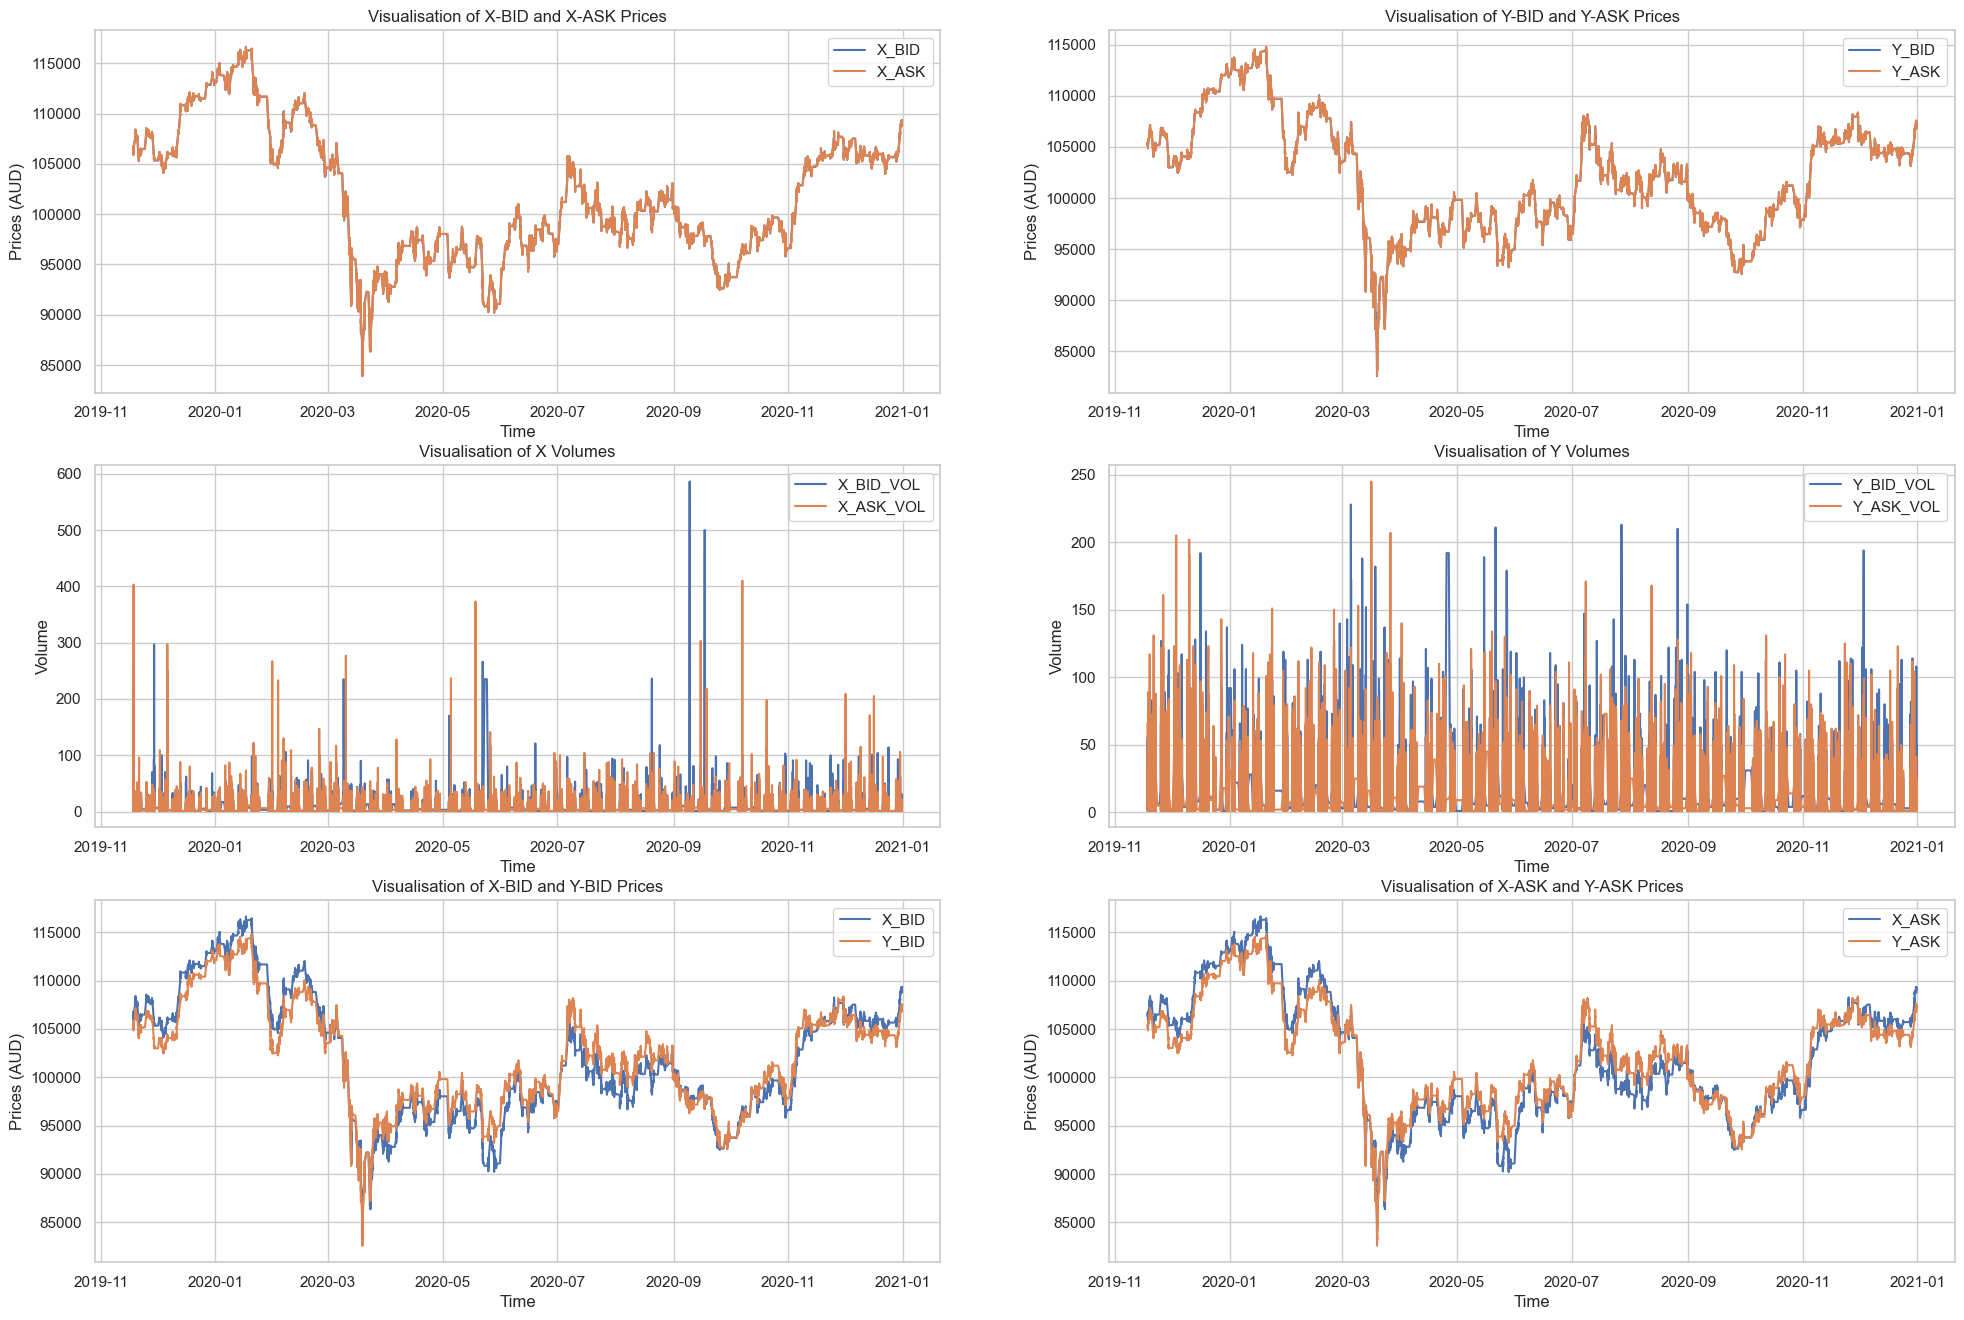

In [3]:
plt.figure(figsize=(24,16))
plt.subplot(3, 2, 1)
plt.plot(df['X_BID'], label='X_BID')
plt.plot(df['X_ASK'], label='X_ASK')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of X-BID and X-ASK Prices')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(df['Y_BID'], label='Y_BID')
plt.plot(df['Y_ASK'], label='Y_ASK')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of Y-BID and Y-ASK Prices')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(df['X_BID_VOL'], label='X_BID_VOL')
plt.plot(df['X_ASK_VOL'], label='X_ASK_VOL')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Visualisation of X Volumes')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(df['Y_BID_VOL'], label='Y_BID_VOL')
plt.plot(df['Y_ASK_VOL'], label='Y_ASK_VOL')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Visualisation of Y Volumes')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(df['X_BID'], label='X_BID')
plt.plot(df['Y_BID'], label='Y_BID')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of X-BID and Y-BID Prices')
plt.legend(loc='best')

plt.subplot(3,2,6)
plt.plot(df['X_ASK'], label='X_ASK')
plt.plot(df['Y_ASK'], label='Y_ASK')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of X-ASK and Y-ASK Prices')
plt.legend(loc='best')

plt.show()

In [808]:
df.corr()

,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
X_BID,1.000000,-0.100079,0.999997,0.081609,0.978944,0.062361,0.978955,0.048193
X_BID_VOL,-0.100079,1.000000,-0.100189,0.030392,-0.087304,0.011525,-0.087409,-0.026351
X_ASK,0.999997,-0.100189,1.000000,0.081370,0.978902,0.062100,0.978917,0.047890
X_ASK_VOL,0.081609,0.030392,0.081370,1.000000,0.078297,0.047101,0.077899,0.066008
Y_BID,0.978944,-0.087304,0.978902,0.078297,1.000000,0.055931,0.999996,0.055853
Y_BID_VOL,0.062361,0.011525,0.062100,0.047101,0.055931,1.000000,0.056046,0.099351
Y_ASK,0.978955,-0.087409,0.978917,0.077899,0.999996,0.056046,1.000000,0.055778
Y_ASK_VOL,0.048193,-0.026351,0.047890,0.066008,0.055853,0.099351,0.055778,1.000000


#### Apparently, both instructments X and Y are not stationary from the plots. X and Y are highly correlated

### Visualization after moving average

#### The raw data visualiztion does not help a lot in terms of recognizing anomalies or periodic patterns. We use moving average with window = 50000 (other might work but 50000 gives a smooth curve) to make curves smoother so that the pattern would be intuitive to identify.

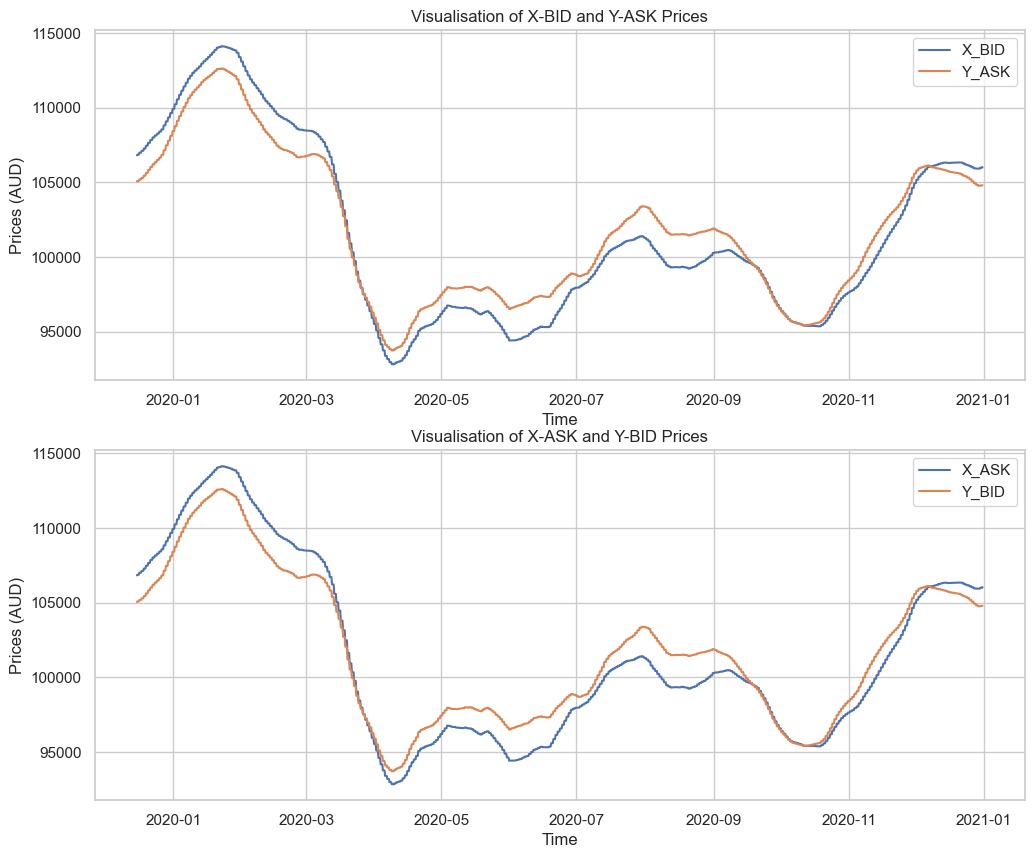

In [259]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(df['X_BID'].rolling(window=50000, center=False).mean(), label='X_BID')
plt.plot(df['Y_ASK'].rolling(window=50000, center=False).mean(), label='Y_ASK')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of X-BID and Y-ASK Prices')
plt.legend(loc='best')


plt.subplot(2,1,2)
plt.plot(df['X_ASK'].rolling(window=50000, center=False).mean(), label='X_ASK')
plt.plot(df['Y_BID'].rolling(window=50000, center=False).mean(), label='Y_BID')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of X-ASK and Y-BID Prices')
plt.legend(loc='best')



plt.show()

#### Since the ask price and bid price are very close relative to the magnitude of the price, we can just observe either of them. We have two interesting findings. First of all, it is worth noting that both instruments X and Y have a huge drop in March, 2020. It is consistenty with the fact the outbreak of COVID19 in  Australia and the corresponding lockdowns' impacts on the economy (https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Australia). Secondly, we can see that both X and Y increase significantly in November, 2020. This is due to the fact the Reserve Bank of Australia lower its interest rate to 0.1% (lowest) (https://www.rba.gov.au/statistics/cash-rate/).

#### We can see that X and Y are highly correlated and the distance of them seems to be very small (not only with similar trend)

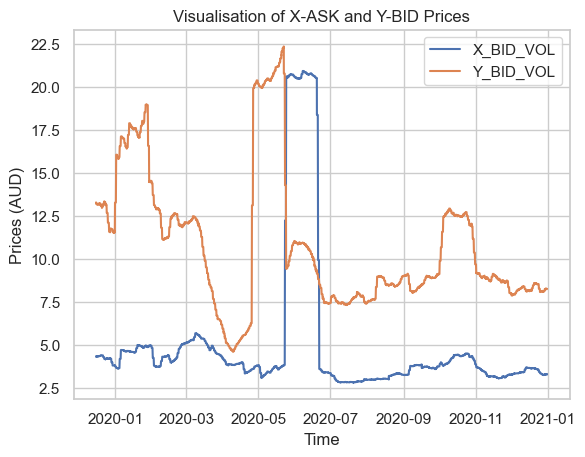

In [731]:
plt.plot(df['X_BID_VOL'].rolling(window=50000, center=False).mean(), label='X_BID_VOL')
plt.plot(df['Y_BID_VOL'].rolling(window=50000, center=False).mean(), label='Y_BID_VOL')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of X-ASK and Y-BID Prices')
plt.legend(loc='best')


#### We can see that there is a huge increase in both bid volumes. This could be due to the fact that three-stage plan to begin easing lockdown restrictions announced. https://www.aph.gov.au/Parliamentary_Business/Committees/Senate/COVID-19/COVID19/Report/section?id=committees%2Freportsen%2F024920%2F79485

## Pricing Relationships

### The distance method

#### We compute the distance between those prices of X and Y to have prelimiary research (without considering constant or linear combination etc)

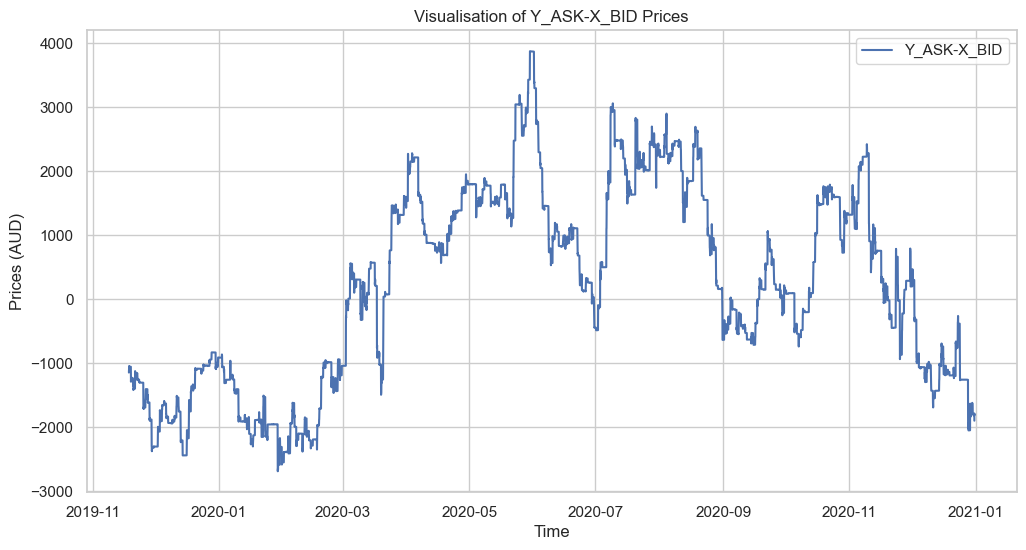

In [134]:
plt.figure(figsize=(12,6))
plt.plot((df['Y_ASK']-df['X_BID']).rolling(window=500, center=False).mean(), label='Y_ASK-X_BID')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of Y_ASK-X_BID Prices')
plt.legend(loc='best')




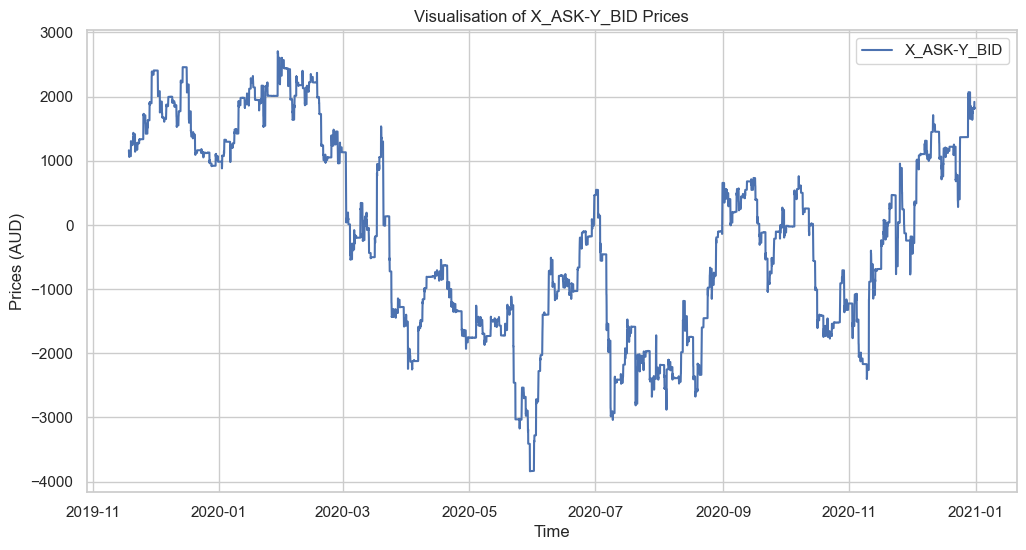

In [135]:
plt.figure(figsize=(12,6))
plt.plot((df['X_ASK']-df['Y_BID']).rolling(window=500, center=False).mean(), label='X_ASK-Y_BID')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of X_ASK-Y_BID Prices')
plt.legend(loc='best')
plt.show()

#### We can see that previous two plots tends to move around the mean. We now need to standardize this distance because the absolute distance might not be the most ideal way of analyzing this trend. For this, we need to use z-scores. A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. 

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

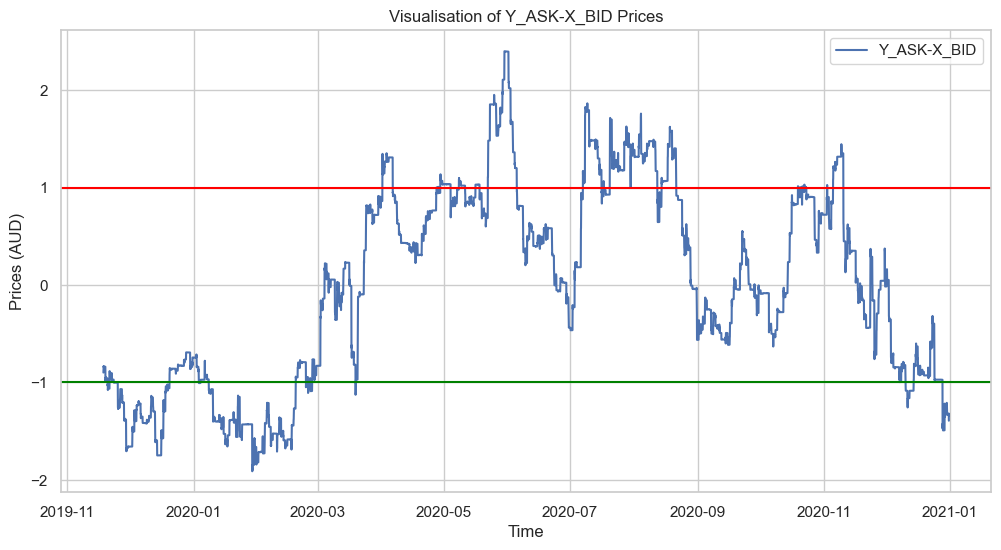

In [136]:

plt.figure(figsize=(12,6))
plt.plot(zscore((df['Y_ASK']-df['X_BID']).rolling(window=500, center=False).mean()), label='Y_ASK-X_BID')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.title('Visualisation of Y_ASK-X_BID Prices')
plt.legend(loc='best')


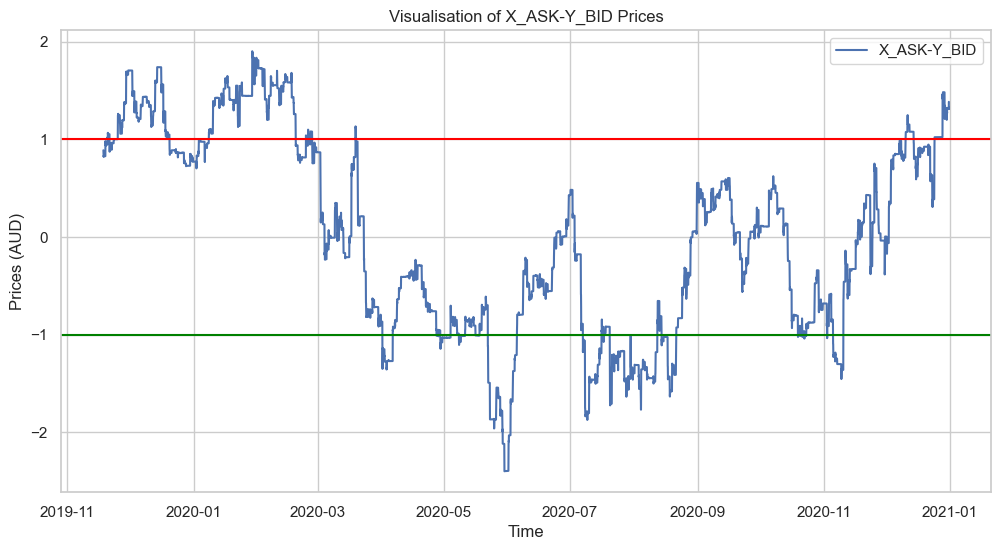

In [137]:
plt.figure(figsize=(12,6))
plt.plot(zscore((df['X_ASK']-df['Y_BID']).rolling(window=500, center=False).mean()), label='X_ASK-Y_BID')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.title('Visualisation of X_ASK-Y_BID Prices')
plt.legend(loc='best')
plt.show()

#### A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

#### whenever the z-score is below -1, meaning we expect the distance  to increase.
#### whenever the z-score is above 1, meaning we expect the distance  to decrease.

#### When the spread diverges by one or more historical standard deviation (calculated in the formation period), we simultaneously open a long and a short position in the pair depending on the direction of the divergence. The two positions are closed (reversed) once the spread converges to zero again. The pair is then monitored for another potential divergence and therefore can complete multiple round-trip trades during the trading period.


#### It seems like that Y_ASK-X_BID and X_ASK-Y_BID are stationary. However, we need to validate this result by further numerical results.  

#### We define a function to test if a series stationary or not under significant level of 0.05 for the following sections

In [ ]:
def stationarity_test(X, cutoff=0.05):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series is likely non-stationary.')

In [158]:
stationarity_test(zscore((df['X_ASK']-df['Y_BID'])), cutoff=0.05)

p-value = 0.31882340548443977 The series is likely non-stationary.


In [159]:
stationarity_test(zscore((df['Y_ASK']-df['X_BID'])), cutoff=0.05)

p-value = 0.3168978590465007 The series is likely non-stationary.


#### It seems like the distanace is not stationary. Hence, this assumption is violated, which means we might consider other signals

### The cointegration method



#### We can write the observation at time $t$ for instrument $X$ and $Y$ as $X_t$ and $Y_t$.

#### If exists a linear combination of the two time series that is stationary, $X_t$ and $Y_t$ are said to be cointegrated. Thus, $X_t$ and $Y_t$  are cointegrated if there exists a non-zero real number $\beta$ such that: $$X_t − \beta Y_t = u_t$$ where $\beta$ is the cointegration coefficient and $u_t$ is a stationary series known as the cointegration errors. 

#### Using the Granger’s theorem, the cointegration relationship can be equivalently shown in an Error Correction Model framework (ECM). Based on ECM, the cointegrated series exhibits long-term equilibrium and, while short-term deviations from this equilibrium can occur, they will be corrected, through time, by the error term in the ECM.


#### Now we can plot the spread of the two time series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities.

#### It is worth noting that since pairs trading is a long-short strategy, modelling this relationship would allow us to take advantage of any short-term deviations by simultaneously buying the undervalued and selling short the overvalued security. Thus, we conside the ask price of X and bid price of Y and vice versa.

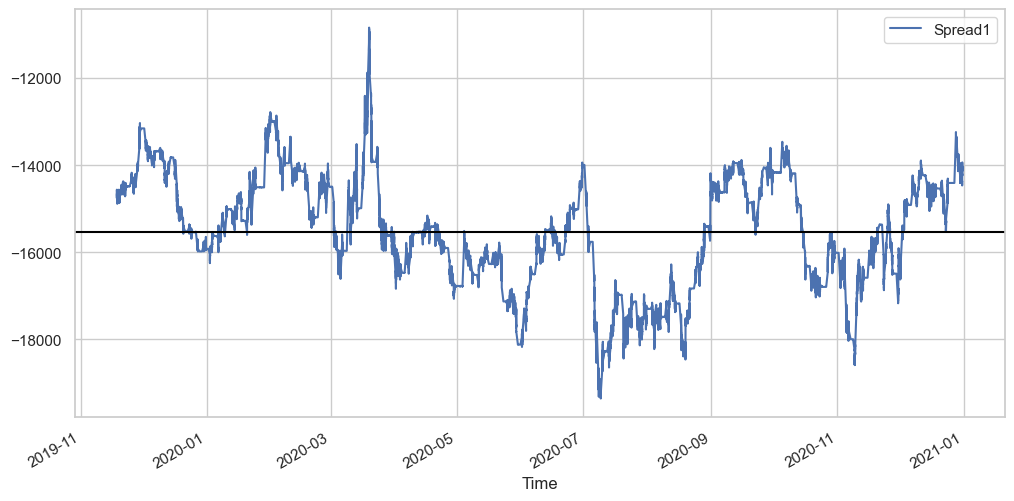

In [484]:
#The following code run linear regression on the two prices
#We find the weights of linear combination by linear regression
S1=df['Y_ASK']
S2=df['X_BID']
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['Y_ASK']
b1 = results.params['Y_ASK']

spread1 = S2 - b1 * S1
spread1.plot(figsize=(12,6))
plt.axhline(spread1.mean(), color='black')
plt.legend(['Spread1'])
plt.title('Visualisation of X_ASK-Y_BID Prices');

In [485]:
stationarity_test(spread1)

p-value = 0.028008088952358384 The series is likely stationary.


#### We can see that the linear combination of two series are indeed stationary. Our pair trading strategy would base on this fact

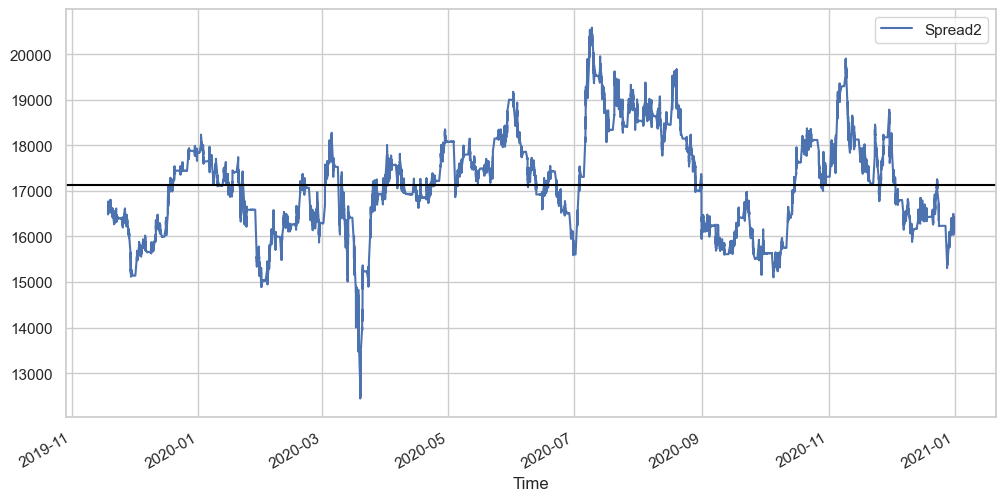

In [486]:
#The following code run linear regression on the two prices
#We find the weights of linear combination by linear regression
S1=df['X_ASK']
S2=df['Y_BID']
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['X_ASK']
b2 = results.params['X_ASK']

spread2 = S2 - b2 * S1
spread2.plot(figsize=(12,6))
plt.axhline(spread2.mean(), color='black')
plt.legend(['Spread2']);


In [97]:
stationarity_test(spread2)

p-value = 0.012126063360348311 The series is likely stationary.


#### We can see that the linear combination of two series are indeed stationary. Our pair trading strategy would base on this fact

#### We also conduct the testing for conintegration to validate our conclusion above (See https://github.com/KidQuant/Pairs-Trading-With-Python/blob/master/PairsTrading.ipynb for details )

In [812]:
score, pvalue, _ = coint(df["Y_ASK"], df["X_BID"])
print(pvalue)

0.04667318375988409


In [811]:
score, pvalue, _ = coint(df["Y_BID"],df["X_ASK"])
print(pvalue)

0.04611583845096353


#### They are indeed cointegrate

#### We standardize the spreads by z-score for better analysis

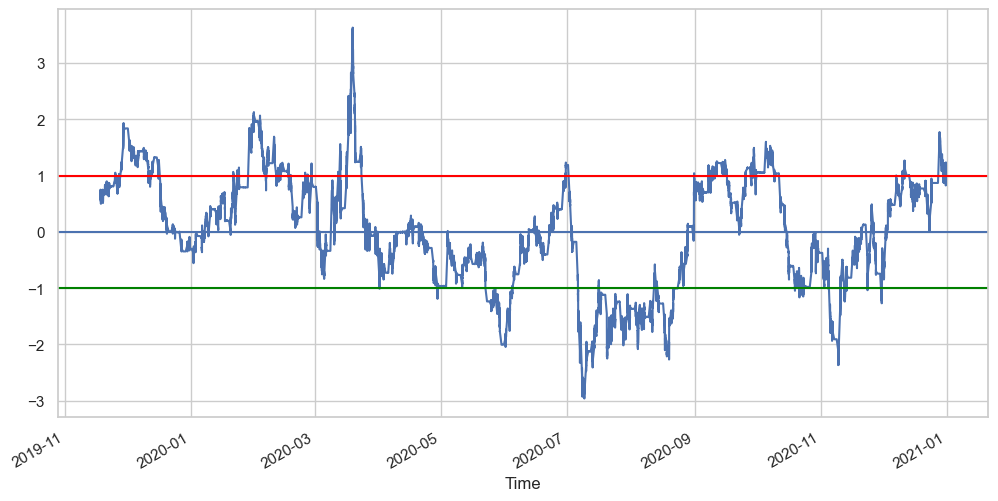

In [487]:
zscore(spread1).plot(figsize=(12,6))
plt.axhline(zscore(spread1).mean())
plt.axhline(1, color='red')
plt.axhline(-1, color='green')
plt.show()



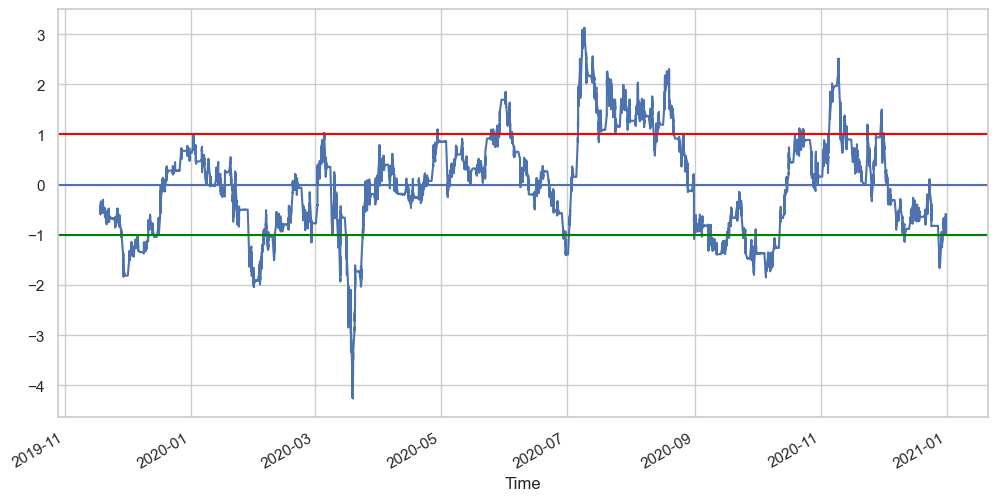

In [488]:
plt.figure(figsize=(24,20))
zscore(spread2).plot(figsize=(12,6))
plt.axhline(zscore(spread2).mean())
plt.axhline(1, color='red')
plt.axhline(-1, color='green')
plt.show()

#### A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

#### whenever the z-score is below -1, meaning we expect the spread  to increase.
#### whenever the z-score is above 1, meaning we expect the spread  to decrease.

#### Similar to the distance method, we simultaneously open and close long and short positions when the normalized spread diverges beyond 1. However, the values of long and short positions vary from those in the distance method.

## Trading Strategy

### Distance Method (General Idea)

#### At the beginning of the trading period, prices are once again rescaled to $1 and the spread is recalculated and monitored.

#### When the spread diverges by one or more historical standard deviation (calculated in the formation period), we simultaneously open a long and a short position in the pair depending on the direction of the divergence. The two positions are closed (reversed) once the spread converges to zero again. The pair is then monitored for another potential divergence and therefore can complete multiple round-trip trades during the trading period.

#### Since the distance is not stationary, we need to explore other methods

### The cointegration method (General Idea)

#### We use the two-step Engle-Granger approach  to test for the existence of cointegration between nominated pairs and to estimate cointegration coefficient $\beta$. In this procedure, the cointegration regression is estimated using OLS in the first step and the error correction model (ECM) is estimated in the second step. For each nominated pair, we then form the spread 
$$\text{spread}=Y_t-\beta X_t$$
#### and calculate z-score of the spread. 
$$\text{spread}_\text{normalized} = \frac{\text{spread}-\mu_\text{spread}}{\sigma_\text{spread}}$$

#### Similar to the distance method, we simultaneously open and close long and short positions when the normalized spread diverges beyond 1. However, the values of long and short positions vary from those in the distance method. 

#### By construction, if the spread drops below −1, we buy 1 dollar worth of stock Y and sell short $\beta$ dollar worth of stock X. Equivalently, we sell short $1/\beta$ dollar worth of stock Y and buy 1 dollar worth of stock X, when the spread moves above the +1 threshold. 

#### We close both positions once the spread returns to zero, which translates into the pair returning to their long-term equilibrium. The pair is again monitored for other potential round-trip trades for the remainder of the trading period.



## Specifically, for this dataset where we do not have trade execution,  our the trade signal is the following:

#### Define $$spread_1 = \frac{(Y_{BID}-\beta_1X_{ASK})-\mu_{hist_1}}{\sigma_{hist_1}}$$ and  $$spread_2 = \frac{(X_{BID}-\beta_2Y_{ASK})-\mu_{hist_2}}{\sigma_{hist_2}}$$ where $\mu_{hist_i}$ and $\sigma_{hist_i}$ are  the corresponding historical mean and standard deviation.

#### we sell short $1/\beta_1$ dollar worth of stock Y and buy 1 dollar worth of stock X when the spread_1  moves above the +1 threshold. 

#### we sell short $1/\beta_2$ dollar worth of stock X and buy 1 dollar worth of stock Y when the spread_2  moves above the +1 threshold. 

#### We close the position when the spreads reach 0, which is the long term equilibiruim under the assumption

### Implementation of the cointegration method 

#### Since the assumption of distance method is violated. We implement the cointegration method only.


In [670]:
#fit the data and calculate beta in the training set


def estimate_beta_mu_sigma(train):
    S1=train['X_ASK']
    S2=train['Y_BID']
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1['X_ASK']
    b1 = results.params['X_ASK']
    spread_hist1 = S2 - b1 * S1
    mu_hist1=spread_hist1.mean()
    sigma_hist1=np.std(spread_hist1)

    S1=train['Y_ASK']
    S2=train['X_BID']
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1['Y_ASK']
    b2 = results.params['Y_ASK']
    spread_hist2 = S2 - b2 * S1
    mu_hist2=spread_hist2.mean()
    sigma_hist2=np.std(spread_hist2)
    return b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2





In [671]:
#calculate two spreads in the test set based on beta, mu, sigma

def standardize_spread(b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2, test):
    
    spread1 = test['Y_BID'] - b1 * test['X_ASK']
    spread1=(spread1-mu_hist1)/np.std(spread_hist1)

    spread2 = test['X_BID'] - b2 * test['Y_ASK']
    spread2=(spread2-mu_hist2)/np.std(spread_hist2)
    return spread1, spread2, b1, b2 



#### We also consider transcation cost in our trading strategy. The cost is based on Comsec's reference. https://www.commsec.com.au/support/rates-and-fees.html

#### Since we have two spreads, which is defined above. During simulation, our total profits would be the sum profit of those two strategy based on the two spreads. 

#### It is worth noting that we use rolling historical data to get the most recent beta, mu and sigma. We choose the rolling historical data to be a window before current time. However, keep fitting data too frequently would lead to time consumption. We use the strategy where data are fitted every windows passed.

In [718]:
def trade_simulation(df,windows):
    money = 0
    countY = 0
    countX = 0
    money_over_time=0*df['X_BID'].copy()
    re_compute_indicator = windows
    for i in range((windows+1),len(df)):#strategy for Y_BID and X_ASK spread
        #update b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2 based on the historical data dynamically
        if re_compute_indicator == windows:#no need to update too frequent since it is time consuming
            train = df[(i-windows):i]
            b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2 = estimate_beta_mu_sigma(train)
            re_compute_indicator = 0
        re_compute_indicator += 1
        test = df[i:(i+1)]
        spread1, spread2, b1, b2 = standardize_spread(b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2, test)
        # Sell Y and buy X if the spread1 is > 1
        if spread1[0] > 1:
            money +=  1*df['Y_BID'][i] - b1*df['X_ASK'][i]
            money -=  (1*df['Y_BID'][i]*0.012 + b1*df['X_ASK'][i]*0.012)#transaction cost
            countY -= 1
            countX += b1
        # close positions if spread is 0
        if spread1[0] < 0:
            money += df['X_BID'][i]*countX - df['Y_ASK'][i]*countY 
            money -= (df['X_BID'][i]*countX*0.012 + df['Y_ASK'][i]*countY*0.012)#transaction cost
            countY = 0
            countX = 0
        money_over_time[i]+=money
    money = 0
    countY = 0
    countX = 0
    re_compute_indicator = windows
    for i in range((windows+1),len(df)):#strategy for X_BID and Y_ASK spread
        #update b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2 based on the historical data dynamically
        if re_compute_indicator == windows:#no need to update too frequent since it is time consuming
            train = df[(i-windows):i]
            b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2 = estimate_beta_mu_sigma(train)
            re_compute_indicator = 0
        re_compute_indicator += 1
        test = df[i:(i+1)]
        spread1, spread2, b1, b2 = standardize_spread(b1, b2, mu_hist1, sigma_hist1, mu_hist2, sigma_hist2, test)
        # Sell X and buy Y if the spread2 is >1
        if spread2[0] > 1:
            money +=  1*df['X_BID'][i] - b2*df['Y_ASK'][i]
            money -=  (1*df['X_BID'][i]*0.012 + b2*df['Y_ASK'][i]*0.012)
            countX -= 1
            countY += b2
        # close positions if spread is 0
        if spread2[0] < 0:
            money +=  df['Y_BID'][i]*countY - df['X_ASK'][i]*countX 
            money -=  (df['Y_BID'][i]*countY*0.012 + df['X_ASK'][i]*countX*0.012)
            countY = 0
            countX = 0
        money_over_time[i]+=money
    return money_over_time

In [719]:
money_over_time=trade_simulation(df=df,windows= 50000)

### Plot the profit of my trading strategy over time. We can see that our money is increasing since the trading strategy is executed. Our method make profits

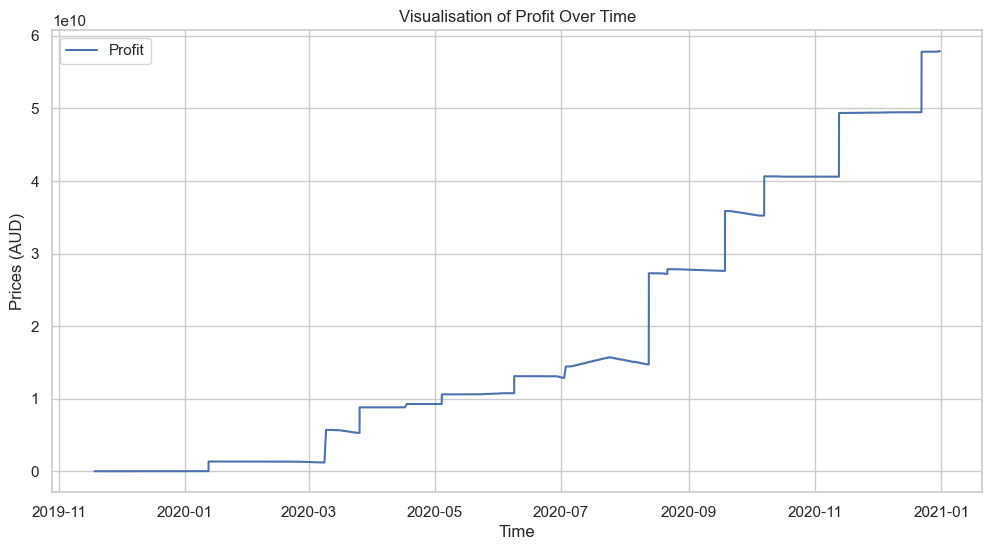

In [722]:
plt.figure(figsize=(12,6))
plt.plot(money_over_time, label='Profit')
plt.xlabel('Time')
plt.ylabel('Prices (AUD)')
plt.title('Visualisation of Profit Over Time')
plt.legend(loc='best')
plt.show()

### Metrics to measure performance of the strategy

#### - Profit and Loss (P&L): 
Calculate the total profit or loss generated by the strategy over a specific time period. This is the most basic and fundamental metric. We show this result in the previous plot.

#### - Return on Investment (ROI):

ROI measures the percentage increase in capital resulting from the trading strategy. It's calculated as (Net Profit / Initial Capital) * 100%. A positive ROI indicates profitability.
#### - Annualized Return:

The annualized return measures the average annual return of the pair trading strategy, which is useful for comparing strategies on an annual basis.
#### - Sharpe Ratio:

The Sharpe Ratio assesses the risk-adjusted return of the strategy. It quantifies how well the strategy has performed relative to the risk taken. A higher Sharpe Ratio indicates better risk-adjusted returns.

#### - Win-Loss Ratio:
The win-loss ratio calculates the number of winning trades (profitable) compared to the number of losing trades (unprofitable). A ratio greater than 1 indicates a favorable strategy.

#### We use Profit and Loss (P&L) to reflect our method performance

### Discussion
We developed a pair trading strategy.  We confirm that instruments X and Y have a stable, long-term relationship.  

We estimate the cointegrating vector, where we run a linear regression. The error term in this linear regression is stationary, which is confirmed by the Augmented Dickey-Fuller (ADF) test. This beta estimate represents the weights assigned to each instrument in the linear combination that forms a stationary spread. We calculate the spread by taking the difference between the prices of the X and Y and applying the weights from the cointegrating vector. The spread is a stationary time series.

Since we have ask/bid prices for X and Y, we have spread1 and spread2. We develop strategies for X_BID and Y_ASK, Y_BID and X_ASK, respectively, following the cointegration method. We set one historical standard deviation is the threshould to open the position and when the spread reaches 0 we close the position. We use dynamic idea to update the estimated beta, spread etc using rolling historical data. By this, we can make sure that short term time series of spread is stiationary.

Our simulation result shows that our strategy works well. It can make profits even when the market is bearish (e.g., during covid 19).



### Limitation 
**Limitations** 
#### - Trade execuation: 
We lack of trade execuation. We cannot make a more precise signal on  trading strategy.

#### - Market depth: 
The market depth is missing since we only have the information for the top level prices. Consequently, we only consider one buying 1 units of the instructment for each transcation and did not consider wether position can be opned or closed with different volume.

#### - Volume: 
Volume seems to be a good indicator for bullish or bearish market but we did not consider utilize this information.

#### - Transaction cost:
In some situations, we can have declining profitability, after accounting for transaction costs. Those volume is important. However, our strategy did not consider such thing.

#### - Impact on the market: 
Due to lack of market depth etc, we cannot evaluate our trading's impact on the market.

#### - Data Dependency:
Our method relies heavily on historical price data. A significant drawback is that the analysis is backward-looking and may not account for evolving market conditions.

#### - Assumption of Stationarity or False Positives:
Our method assumes that the price series are stationary. If the underlying assets are not stationary, the cointegration test may yield misleading results, leading to spurious cointegration.

#### - Exogenous Events or Changing Relationships:
Unexpected exogenous events, such as geopolitical events or natural disasters, can disrupt the cointegrated relationship between assets and lead to significant losses.

### Further Research

**Further Research** 
#### - Copula method:
Due to the properties of copulas in allowing the freedom to select marginal distributions and to flexibly model joint distributions (particularly lower tail dependence) copulas have also been frequently used in risk management and asset allocation. It would be interesting to compare the performance of distance method, cointegration and copula.

#### - Selection of pairs: 
Given of all possible combinations of stock pairs. How can we find the most "suitable" pairs? Usually, people use the least sum of squared spreads to find such pairs.


#### - Market Regime Detection: 
Create algorithms that can detect shifts in market regimes and adjust trading strategies accordingly. For instance, a strategy suitable for a bull market may require adaptation in a bear market.

#### - Social Media and Sentiment Analysis: 
Explore the integration of sentiment analysis from social media and news sources into pair trading strategies to gauge market sentiment and anticipate price movements.

#### - Machine Learning and AI Integration: 
Explore the integration of machine learning and artificial intelligence techniques for improved signal generation and decision-making. These technologies can help identify more complex patterns and relationships in asset pairs.

#### - Market Analysis: 
Study the impact of market microstructure on pair trading, including factors such as market order flow, liquidity, and bid-ask spreads. Develop strategies that can adapt to changing market conditions.